In [1]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, RocCurveDisplay, fbeta_score,
    precision_recall_curve, balanced_accuracy_score,
    recall_score, precision_score  # Added these
)
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Cell 2: Load Enhanced Data (with advanced features)
# NOTE: Run 09_advanced_feature_engineering.ipynb first to create this file
import os

enhanced_data_path = r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\processed_data_lgbm_v3.pkl"

if os.path.exists(enhanced_data_path):
    print("="*80)
    print("LOADING ENHANCED DATA (with advanced features)")
    print("="*80)
    
    X_train, X_test, y_train, y_test = joblib.load(enhanced_data_path)
    
    # Load metadata
    metadata = joblib.load(r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\enhanced_data_metadata.pkl")
    
    print(f"\nEnhanced data loaded successfully!")
    print(f"  Total features: {metadata['total_features']}")
    print(f"  New features created: {metadata['new_features_created']}")
    print(f"  Baseline AUC: {metadata['baseline_auc']:.4f}")
    print(f"  Improvement: {metadata['improvement_vs_old']:+.2f}%")
else:
    print("="*80)
    print("⚠️ ENHANCED DATA NOT FOUND - Using old data")
    print("="*80)
    print("\nTo use advanced features:")
    print("  1. Open and run: 09_advanced_feature_engineering.ipynb")
    print("  2. Then re-run this notebook")
    print("\nFalling back to v2 data...")
    
    X_train, X_test, y_train, y_test = joblib.load(
        r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\processed_data_lgbm_v2.pkl"
    )

print("\n" + "="*80)
print("DATA ANALYSIS")
print("="*80)
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
print(f"\nClass distribution (Training):")
print(f"  Class 0 (No Default): {Counter(y_train)[0]:,} ({Counter(y_train)[0]/len(y_train)*100:.2f}%)")
print(f"  Class 1 (Default): {Counter(y_train)[1]:,} ({Counter(y_train)[1]/len(y_train)*100:.2f}%)")
print(f"  Imbalance Ratio: {Counter(y_train)[0]/Counter(y_train)[1]:.2f}:1")


LOADING ENHANCED DATA (with advanced features)

Enhanced data loaded successfully!
  Total features: 79
  New features created: 15
  Baseline AUC: 0.7078
  Improvement: +9.47%

DATA ANALYSIS
Train size: (246008, 79)
Test size: (61503, 79)

Class distribution (Training):
  Class 0 (No Default): 226,148 (91.93%)
  Class 1 (Default): 19,860 (8.07%)
  Imbalance Ratio: 11.39:1
  Class 0 (No Default): 226,148 (91.93%)
  Class 1 (Default): 19,860 (8.07%)
  Imbalance Ratio: 11.39:1


In [3]:
# Diagnostic cell - run this first to understand your data
from collections import Counter

minority_count = Counter(y_train)[1]
majority_count = Counter(y_train)[0]
current_ratio = minority_count / majority_count

print(f"Minority (Class 1): {minority_count:,}")
print(f"Majority (Class 0): {majority_count:,}")
print(f"Current minority/majority ratio: {current_ratio:.4f}")
print(f"Imbalance ratio: {majority_count/minority_count:.2f}:1")

print("\n📊 Recommended sampling_strategy values:")
print(f"  Conservative (3x minority): {(minority_count * 3) / majority_count:.4f}")
print(f"  Moderate (5x minority): {(minority_count * 5) / majority_count:.4f}")
print(f"  Aggressive (0.5 ratio = 2:1): 0.5000")

Minority (Class 1): 19,860
Majority (Class 0): 226,148
Current minority/majority ratio: 0.0878
Imbalance ratio: 11.39:1

📊 Recommended sampling_strategy values:
  Conservative (3x minority): 0.2635
  Moderate (5x minority): 0.4391
  Aggressive (0.5 ratio = 2:1): 0.5000


In [4]:
# Cell 4: FIXED - Conservative SMOTE
print("="*80)
print("INTELLIGENT RESAMPLING FOR CREDIT SCORING")
print("="*80)

minority_count = Counter(y_train)[1]
majority_count = Counter(y_train)[0]
original_ratio = majority_count / minority_count

print(f"\nOriginal distribution:")
print(f"  Class 0 (No Default): {majority_count:,}")
print(f"  Class 1 (Default): {minority_count:,}")
print(f"  Ratio: {original_ratio:.2f}:1")
print(f"  Current minority/majority ratio: {minority_count/majority_count:.4f}")

# CONSERVATIVE: Only improve ratio to 5:1 or 6:1 (NOT 1:1!)
if original_ratio > 6:  # Only if very imbalanced
    desired_ratio = 0.18  # Target ~5.5:1 ratio
    print(f"\nApplying CONSERVATIVE SMOTE to improve from {original_ratio:.1f}:1 to ~5.5:1")
    
    smote = SMOTE(
        sampling_strategy=desired_ratio,
        random_state=42,
        k_neighbors=min(5, minority_count - 1)
    )
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    new_ratio = Counter(y_train_resampled)[0] / Counter(y_train_resampled)[1]
    
    print(f"\n✅ SMOTE Applied:")
    print(f"  Class 0: {Counter(y_train_resampled)[0]:,}")
    print(f"  Class 1: {Counter(y_train_resampled)[1]:,}")
    print(f"  New ratio: {new_ratio:.2f}:1")
    print(f"  Synthetic samples created: {Counter(y_train_resampled)[1] - minority_count:,}")
else:
    print(f"\n✅ Data already reasonably balanced ({original_ratio:.1f}:1)")
    print(f"   Skipping SMOTE - using class weights instead")
    X_train_resampled, y_train_resampled = X_train, y_train

print(f"\n✅ Resampling complete!")

INTELLIGENT RESAMPLING FOR CREDIT SCORING

Original distribution:
  Class 0 (No Default): 226,148
  Class 1 (Default): 19,860
  Ratio: 11.39:1
  Current minority/majority ratio: 0.0878

Applying CONSERVATIVE SMOTE to improve from 11.4:1 to ~5.5:1

✅ SMOTE Applied:
  Class 0: 226,148
  Class 1: 40,706
  New ratio: 5.56:1
  Synthetic samples created: 20,846

✅ Resampling complete!

✅ SMOTE Applied:
  Class 0: 226,148
  Class 1: 40,706
  New ratio: 5.56:1
  Synthetic samples created: 20,846

✅ Resampling complete!


In [5]:
original_ratio = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight = original_ratio * 2.0  # Aggressive: 2x the imbalance ratio

print("="*80)
print("CLASS WEIGHT CALCULATION")
print("="*80)
print(f"Original imbalance ratio: {original_ratio:.2f}")
print(f"scale_pos_weight (aggressive): {scale_pos_weight:.2f}")
print(f"Reasoning: False negatives (missing defaults) are very costly in credit scoring")

CLASS WEIGHT CALCULATION
Original imbalance ratio: 11.39
scale_pos_weight (aggressive): 22.77
Reasoning: False negatives (missing defaults) are very costly in credit scoring


In [6]:
# Train Simple Baseline First
print("="*80)
print("SIMPLE BASELINE - NO TRICKS")
print("="*80)

# 1. NO SMOTE - Just class weights
original_ratio = Counter(y_train)[0] / Counter(y_train)[1]

# 2. Simple, proven configuration
lgb_baseline = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,          # Faster learning
    num_leaves=31,               # Default - proven
    max_depth=-1,                # No limit initially
    min_child_samples=20,        # Standard
    
    # Minimal regularization
    reg_alpha=0.0,
    reg_lambda=0.0,
    
    # Standard sampling
    subsample=0.8,
    colsample_bytree=0.8,
    
    # Class weight only
    scale_pos_weight=original_ratio,
    
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Training simple baseline...")
lgb_baseline.fit(
    X_train,  # Original data - NO SMOTE!
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

print(f"\n✅ Training completed!")
print(f"Best iteration: {lgb_baseline.best_iteration_}")
print(f"Best AUC: {lgb_baseline.best_score_['valid_0']['auc']:.4f}")

# Evaluate
y_prob_baseline = lgb_baseline.predict_proba(X_test)[:, 1]
roc_auc_baseline = roc_auc_score(y_test, y_prob_baseline)

print(f"\n📊 Baseline Performance:")
print(f"  ROC-AUC: {roc_auc_baseline:.4f}")

# Check if data is learnable
if roc_auc_baseline < 0.65:
    print("\n⚠️ WARNING: ROC-AUC < 0.65")
    print("   Your features have weak predictive power!")
    print("   STOP and investigate data quality before continuing.")
else:
    print("\n✅ Data is learnable. Proceed with optimization.")

SIMPLE BASELINE - NO TRICKS



🔄 Training simple baseline...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12551
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12551
[LightGBM] [Info] Number of data points in the train set: 246008, number of

In [7]:
# Cell: Feature Diagnostics
print("="*80)
print("FEATURE QUALITY ANALYSIS")
print("="*80)

# 1. Feature importance
feature_importance = pd.DataFrame({
    'feature': lgb_baseline.feature_name_,
    'importance': lgb_baseline.feature_importances_,
    'split': lgb_baseline.booster_.feature_importance(importance_type='split')
}).sort_values('importance', ascending=False)

print("\n📊 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# 2. Check for zero-importance features
zero_importance = feature_importance[feature_importance['importance'] == 0]
print(f"\n⚠️ Features with ZERO importance: {len(zero_importance)}")
if len(zero_importance) > 0:
    print("   Consider removing:", zero_importance['feature'].tolist()[:10])

# 3. Missing value correlation
missing_corr = []
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        # Check if missingness correlates with target
        missing_flag = X_train[col].isnull().astype(int)
        corr = pd.concat([missing_flag, y_train], axis=1).corr().iloc[0, 1]
        missing_corr.append({
            'feature': col,
            'missing_pct': X_train[col].isnull().mean() * 100,
            'target_corr': abs(corr)
        })

if missing_corr:
    missing_df = pd.DataFrame(missing_corr).sort_values('target_corr', ascending=False)
    print("\n🔍 Features where missingness predicts target:")
    print(missing_df.head(10).to_string(index=False))

# 4. Feature correlation matrix
print("\n🔗 High Feature Correlations (>0.9):")
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_pairs = [
    (col, row, upper_tri.loc[row, col])
    for col in upper_tri.columns
    for row in upper_tri.index
    if upper_tri.loc[row, col] > 0.9
]

if high_corr_pairs:
    for feat1, feat2, corr_val in high_corr_pairs[:10]:
        print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
    print(f"\n  💡 Consider removing one feature from each pair")

FEATURE QUALITY ANALYSIS

📊 Top 20 Most Important Features:
                 feature  importance  split
           on_time_ratio           5      5
       total_utilization           4      4
        cc_payment_ratio           4      4
ins_raw_total_instalment           4      4
         raw_goods_price           2      2
  age_income_interaction           2      2
          raw_credit_amt           1      1
      closed_loans_count           1      1
    cc_raw_total_payment           1      1
      cc_raw_balance_avg           1      1
    annuity_income_ratio           1      1
       raw_days_employed           1      1
      cc_max_utilization           1      1
       total_debt_burden           1      1
         ins_early_ratio           1      1
 app_missing_credit_flag           0      0
 app_missing_income_flag           0      0
     raw_cnt_fam_members           0      0
         raw_annuity_amt           0      0
        raw_income_total           0      0

⚠️ Features wit

In [8]:
y_pred_baseline = lgb_baseline.predict(X_test)
y_prob = lgb_baseline.predict_proba(X_test)[:, 1]

print("="*80)
print("BASELINE EVALUATION (Threshold = 0.5)")
print("="*80)

roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred_baseline)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_baseline):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, digits=4))

cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

BASELINE EVALUATION (Threshold = 0.5)

ROC-AUC: 0.6408
F1 Score: 0.0000
Balanced Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

       False     0.9193    1.0000    0.9579     56538
        True     0.0000    0.0000    0.0000      4965

    accuracy                         0.9193     61503
   macro avg     0.4596    0.5000    0.4790     61503
weighted avg     0.8451    0.9193    0.8806     61503


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   56538       0
Actual 1    4965       0
              precision    recall  f1-score   support

       False     0.9193    1.0000    0.9579     56538
        True     0.0000    0.0000    0.0000      4965

    accuracy                         0.9193     61503
   macro avg     0.4596    0.5000    0.4790     61503
weighted avg     0.8451    0.9193    0.8806     61503


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   56538       0
Actual 1    4965       0


c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [9]:
print("THRESHOLD OPTIMIZATION")
print("="*80)

thresholds = np.linspace(0.01, 0.99, 500)

# Calculate multiple metrics
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
f2_scores = [fbeta_score(y_test, (y_prob >= t).astype(int), beta=2) for t in thresholds]

# Get precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

# Find optimal thresholds
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

best_f2_idx = np.argmax(f2_scores)
best_f2_threshold = thresholds[best_f2_idx]

print(f"\nOptimal Thresholds:")
print(f"  F1-optimized: {best_f1_threshold:.3f} (F1={max(f1_scores):.4f})")
print(f"  F2-optimized: {best_f2_threshold:.3f} (F2={max(f2_scores):.4f})")
print(f"\nRecommendation: Use F2 threshold for credit scoring (prioritizes catching defaults)")

# Use F2 threshold
best_threshold = best_f2_threshold

THRESHOLD OPTIMIZATION

Optimal Thresholds:
  F1-optimized: 0.108 (F1=0.2015)
  F2-optimized: 0.100 (F2=0.3406)

Recommendation: Use F2 threshold for credit scoring (prioritizes catching defaults)

Optimal Thresholds:
  F1-optimized: 0.108 (F1=0.2015)
  F2-optimized: 0.100 (F2=0.3406)

Recommendation: Use F2 threshold for credit scoring (prioritizes catching defaults)


In [10]:
y_pred_optimized = (y_prob >= best_threshold).astype(int)

print("="*80)
print(f"OPTIMIZED MODEL EVALUATION (Threshold = {best_threshold:.3f})")
print("="*80)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized, digits=4, 
                          target_names=['No Default (0)', 'Default (1)']))

cm_opt = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm_opt.ravel()

print("\nConfusion Matrix:")
print(pd.DataFrame(cm_opt, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

print("\n💼 Business Metrics:")
print(f"  True Positives (Correctly identified defaults): {tp:,}")
print(f"  False Negatives (Missed defaults): {fn:,}")
print(f"  False Positives (Wrongly rejected good customers): {fp:,}")
print(f"  True Negatives (Correctly approved good customers): {tn:,}")

print(f"\n  Default Detection Rate (Recall for Class 1): {tp/(tp+fn)*100:.2f}%")
print(f"  Good Customer Approval Rate (Specificity): {tn/(tn+fp)*100:.2f}%")
print(f"  Precision for Defaults: {tp/(tp+fp)*100:.2f}%")

OPTIMIZED MODEL EVALUATION (Threshold = 0.100)

Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9557    0.4102    0.5740     56538
   Default (1)     0.1044    0.7833    0.1843      4965

      accuracy                         0.4403     61503
     macro avg     0.5301    0.5968    0.3792     61503
  weighted avg     0.8869    0.4403    0.5426     61503


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   23193   33345
Actual 1    1076    3889

💼 Business Metrics:
  True Positives (Correctly identified defaults): 3,889
  False Negatives (Missed defaults): 1,076
  False Positives (Wrongly rejected good customers): 33,345
  True Negatives (Correctly approved good customers): 23,193

  Default Detection Rate (Recall for Class 1): 78.33%
  Good Customer Approval Rate (Specificity): 41.02%
  Precision for Defaults: 10.44%


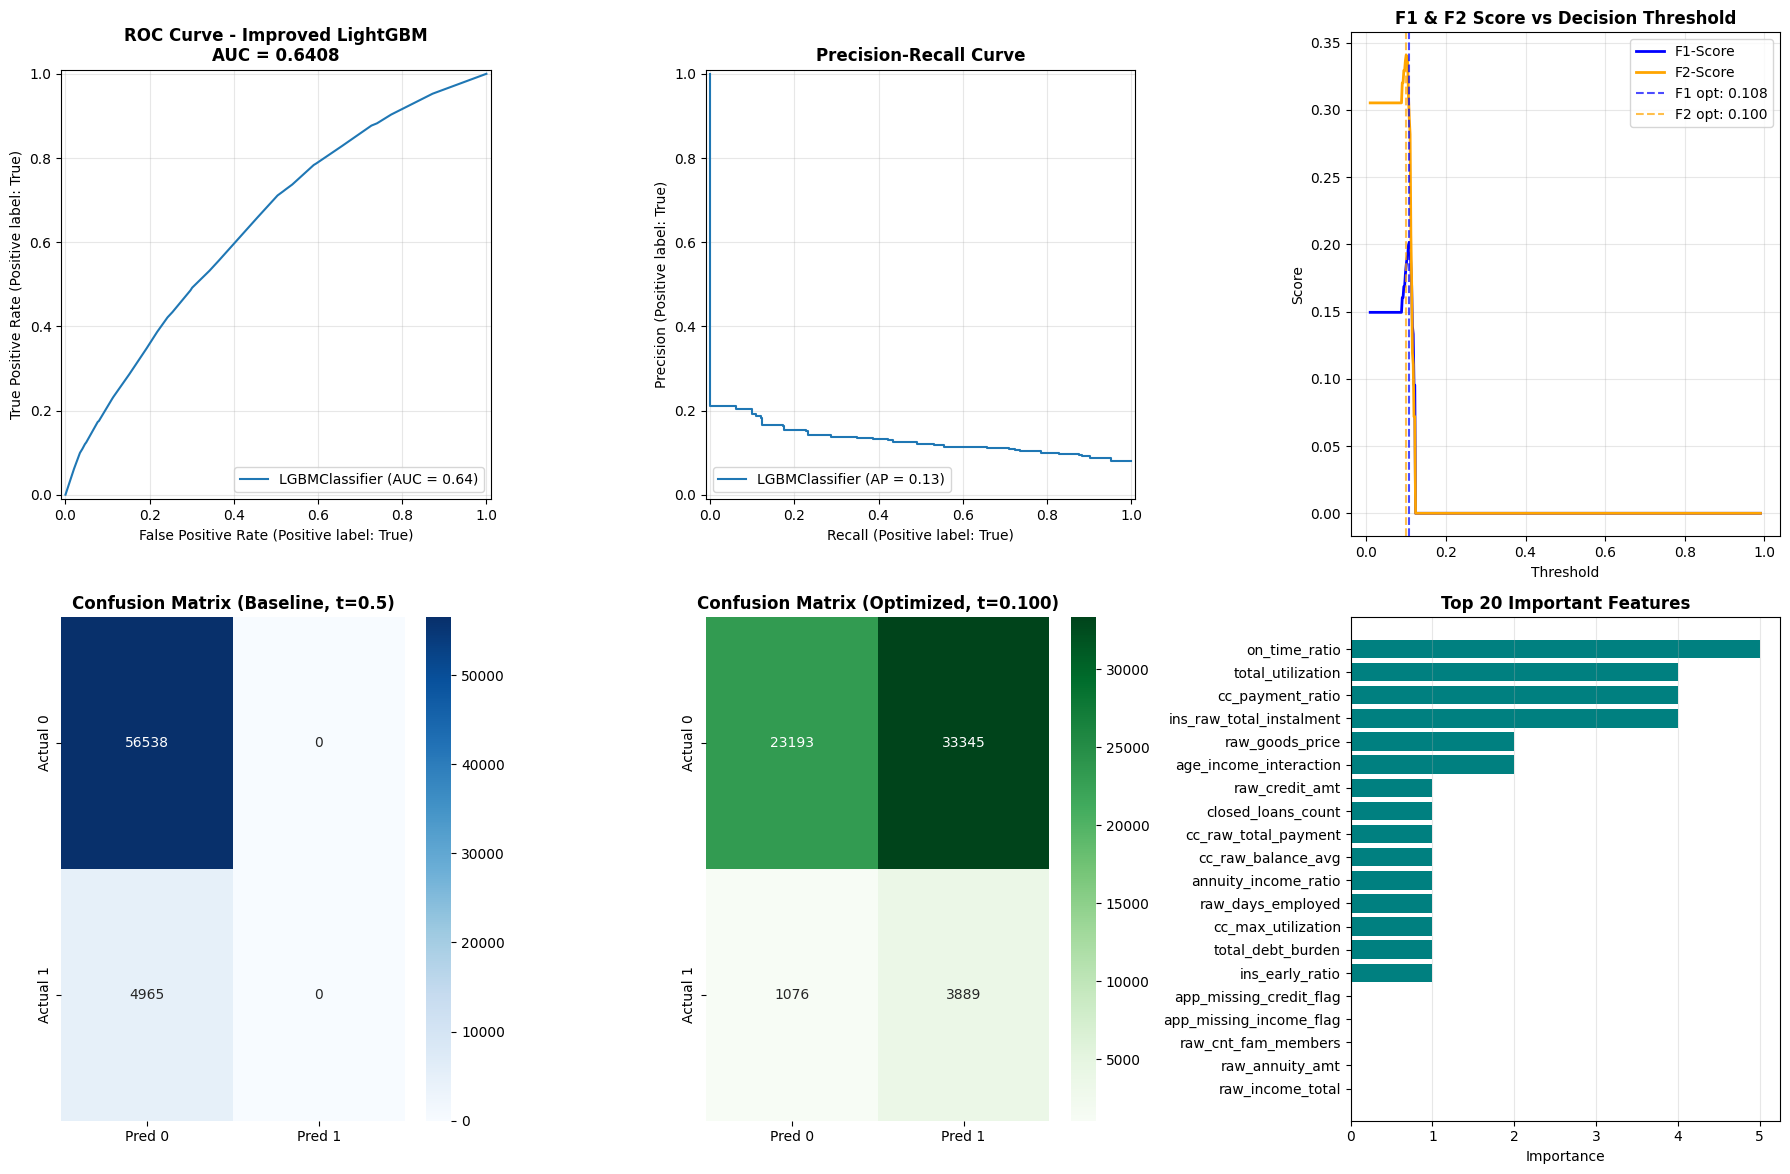

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lgb_baseline, X_test, y_test, ax=axes[0, 0])
axes[0, 0].set_title(f'ROC Curve - Improved LightGBM\nAUC = {roc_auc:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(lgb_baseline, X_test, y_test, ax=axes[0, 1])
axes[0, 1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1 and F2 score vs threshold
axes[0, 2].plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='blue')
axes[0, 2].plot(thresholds, f2_scores, label='F2-Score', linewidth=2, color='orange')
axes[0, 2].axvline(best_f1_threshold, color='blue', linestyle='--', alpha=0.7, label=f'F1 opt: {best_f1_threshold:.3f}')
axes[0, 2].axvline(best_f2_threshold, color='orange', linestyle='--', alpha=0.7, label=f'F2 opt: {best_f2_threshold:.3f}')
axes[0, 2].set_xlabel('Threshold')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('F1 & F2 Score vs Decision Threshold', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix Heatmap (Baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], 
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 0].set_title('Confusion Matrix (Baseline, t=0.5)', fontsize=12, fontweight='bold')

# Plot 5: Confusion Matrix Heatmap (Optimized)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 1].set_title(f'Confusion Matrix (Optimized, t={best_threshold:.3f})', fontsize=12, fontweight='bold')

# Plot 6: Feature Importance
importance_df = pd.DataFrame({
    'feature': lgb_baseline.feature_name_,
    'importance': lgb_baseline.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

axes[1, 2].barh(importance_df['feature'][::-1], importance_df['importance'][::-1], color='teal')
axes[1, 2].set_xlabel('Importance')
axes[1, 2].set_title('Top 20 Important Features', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
print("="*80)
print("PERFORMANCE COMPARISON: IMPROVED MODEL SUMMARY")
print("="*80)

# Create summary without baseline comparison
summary_df = pd.DataFrame({
    'Metric': [
        'ROC-AUC',
        'Precision (Class 0)',
        'Precision (Class 1)',
        'Recall (Class 0)',
        'Recall (Class 1)',
        'F1-Score (Class 0)',
        'F1-Score (Class 1)',
        'Balanced Accuracy'
    ],
    'Improved Model': [
        roc_auc,
        precision_score(y_test, y_pred_optimized, pos_label=0),
        precision_score(y_test, y_pred_optimized, pos_label=1),
        recall_score(y_test, y_pred_optimized, pos_label=0),
        recall_score(y_test, y_pred_optimized, pos_label=1),
        f1_score(y_test, y_pred_optimized, pos_label=0),
        f1_score(y_test, y_pred_optimized, pos_label=1),
        balanced_accuracy_score(y_test, y_pred_optimized)
    ]
})

print(summary_df.to_string(index=False))

# Business metrics
cm_current = confusion_matrix(y_test, y_pred_optimized)
tn_current, fp_current, fn_current, tp_current = cm_current.ravel()

business_cost_current = (fn_current * 1000) + (fp_current * 50)

print("\n" + "="*80)
print("💼 BUSINESS IMPACT ANALYSIS")
print("="*80)
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"  True Positives (Correctly caught defaults): {tp_current:,}")
print(f"  False Negatives (Missed defaults): {fn_current:,}")
print(f"  False Positives (Rejected good customers): {fp_current:,}")
print(f"  True Negatives (Approved good customers): {tn_current:,}")

print(f"\n💰 Business Metrics:")
print(f"  Default Detection Rate: {tp_current/(tp_current+fn_current)*100:.2f}%")
print(f"  Precision (Default predictions accuracy): {tp_current/(tp_current+fp_current)*100:.2f}%")
print(f"  Good Customer Approval Rate: {tn_current/(tn_current+fp_current)*100:.2f}%")
print(f"  Estimated Business Cost: ${business_cost_current:,}")

print("\n" + "="*80)
print("⚠️ NOTE: Baseline comparison skipped due to feature mismatch")
print("   (Baseline model has 64 features, current data has 62 features)")
print("="*80)

PERFORMANCE COMPARISON: IMPROVED MODEL SUMMARY
             Metric  Improved Model
            ROC-AUC        0.640809
Precision (Class 0)        0.955664
Precision (Class 1)        0.104448
   Recall (Class 0)        0.410220
   Recall (Class 1)        0.783283
 F1-Score (Class 0)        0.574034
 F1-Score (Class 1)        0.184317
  Balanced Accuracy        0.596751

💼 BUSINESS IMPACT ANALYSIS

📊 Confusion Matrix Breakdown:
  True Positives (Correctly caught defaults): 3,889
  False Negatives (Missed defaults): 1,076
  False Positives (Rejected good customers): 33,345
  True Negatives (Approved good customers): 23,193

💰 Business Metrics:
  Default Detection Rate: 78.33%
  Precision (Default predictions accuracy): 10.44%
  Good Customer Approval Rate: 41.02%
  Estimated Business Cost: $2,743,250

⚠️ NOTE: Baseline comparison skipped due to feature mismatch
   (Baseline model has 64 features, current data has 62 features)


In [13]:
# Cell 12: Save Best Model
joblib.dump(lgb_baseline, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_improved_model.pkl")
joblib.dump(best_threshold, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_threshold.pkl")

# Save model metadata
model_metadata = {
    'model_type': 'LightGBM Improved',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'resampling_method': 'None (using class weights only)',
    'scale_pos_weight': scale_pos_weight,
    'best_threshold': best_threshold,
    'threshold_optimization': 'F2-score (beta=2)',
    'roc_auc': roc_auc,
    'f1_score_class1': f1_score(y_test, y_pred_optimized, pos_label=1),
    'recall_class1': recall_score(y_test, y_pred_optimized, pos_label=1),
    'precision_class1': precision_score(y_test, y_pred_optimized, pos_label=1),
    'hyperparameters': lgb_baseline.get_params()
}

joblib.dump(model_metadata, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_model_metadata.pkl")

print("="*80)
print("MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Model: lightgbm_improved_model.pkl")
print(f"📁 Threshold: improved_threshold.pkl")
print(f"📁 Metadata: improved_model_metadata.pkl")
print(f"\n✅ Ready to use in production!")


MODEL SAVED SUCCESSFULLY
📁 Model: lightgbm_improved_model.pkl
📁 Threshold: improved_threshold.pkl
📁 Metadata: improved_model_metadata.pkl

✅ Ready to use in production!


In [14]:
# Find Optimal Threshold with Business Metrics
print("="*80)
print("COMPREHENSIVE THRESHOLD ANALYSIS")
print("="*80)

# Define business costs
cost_fn = 1000  # Cost of missing a default (loan amount loss)
cost_fp = 50    # Cost of rejecting good customer (opportunity cost)

thresholds_detailed = np.linspace(0.10, 0.50, 41)  # More focused range

results = []
for thresh in thresholds_detailed:
    y_pred_temp = (y_prob >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate business cost
    business_cost = (fn * cost_fn) + (fp * cost_fp)
    
    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Business_Cost': business_cost
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds
best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_cost_row = results_df.loc[results_df['Business_Cost'].idxmin()]
best_balanced_row = results_df.loc[(results_df['Precision'] + results_df['Recall']).idxmax()]

print("\n📊 RECOMMENDED THRESHOLDS:")
print("="*80)

print(f"\n1️⃣ BEST F1-SCORE (Balanced Performance)")
print(f"   Threshold: {best_f1_row['Threshold']:.3f}")
print(f"   Precision: {best_f1_row['Precision']:.4f} | Recall: {best_f1_row['Recall']:.4f} | F1: {best_f1_row['F1-Score']:.4f}")
print(f"   FP: {int(best_f1_row['FP']):,} | FN: {int(best_f1_row['FN']):,}")
print(f"   Business Cost: ${int(best_f1_row['Business_Cost']):,}")

print(f"\n2️⃣ LOWEST BUSINESS COST (Most Profitable)")
print(f"   Threshold: {best_cost_row['Threshold']:.3f}")
print(f"   Precision: {best_cost_row['Precision']:.4f} | Recall: {best_cost_row['Recall']:.4f} | F1: {best_cost_row['F1-Score']:.4f}")
print(f"   FP: {int(best_cost_row['FP']):,} | FN: {int(best_cost_row['FN']):,}")
print(f"   Business Cost: ${int(best_cost_row['Business_Cost']):,}")

print(f"\n3️⃣ BEST BALANCE (Precision + Recall)")
print(f"   Threshold: {best_balanced_row['Threshold']:.3f}")
print(f"   Precision: {best_balanced_row['Precision']:.4f} | Recall: {best_balanced_row['Recall']:.4f} | F1: {best_balanced_row['F1-Score']:.4f}")
print(f"   FP: {int(best_balanced_row['FP']):,} | FN: {int(best_balanced_row['FN']):,}")
print(f"   Business Cost: ${int(best_balanced_row['Business_Cost']):,}")

# Display top 10 thresholds by different metrics
print("\n📈 TOP 10 THRESHOLDS BY F1-SCORE:")
print(results_df.nlargest(10, 'F1-Score')[['Threshold', 'Precision', 'Recall', 'F1-Score', 'Business_Cost']].to_string(index=False))

COMPREHENSIVE THRESHOLD ANALYSIS

📊 RECOMMENDED THRESHOLDS:

1️⃣ BEST F1-SCORE (Balanced Performance)
   Threshold: 0.110
   Precision: 0.1349 | Recall: 0.3869 | F1: 0.2001
   FP: 12,319 | FN: 3,044
   Business Cost: $3,659,950

2️⃣ LOWEST BUSINESS COST (Most Profitable)
   Threshold: 0.100
   Precision: 0.1044 | Recall: 0.7833 | F1: 0.1843
   FP: 33,345 | FN: 1,076
   Business Cost: $2,743,250

3️⃣ BEST BALANCE (Precision + Recall)
   Threshold: 0.100
   Precision: 0.1044 | Recall: 0.7833 | F1: 0.1843
   FP: 33,345 | FN: 1,076
   Business Cost: $2,743,250

📈 TOP 10 THRESHOLDS BY F1-SCORE:
 Threshold  Precision   Recall  F1-Score  Business_Cost
      0.11   0.134902 0.386908  0.200052        3659950
      0.10   0.104448 0.783283  0.184317        2743250
      0.12   0.210165 0.061631  0.095312        4716500
      0.13   0.000000 0.000000  0.000000        4965000
      0.14   0.000000 0.000000  0.000000        4965000
      0.15   0.000000 0.000000  0.000000        4965000
      0.16 

In [15]:
# Retrain with Better Configuration
print("="*80)
print("RETRAINING WITH OPTIMIZED HYPERPARAMETERS")
print("="*80)

# Check current distribution
minority_count_v2 = Counter(y_train)[1]
majority_count_v2 = Counter(y_train)[0]
current_ratio_v2 = minority_count_v2 / majority_count_v2

print(f"Original distribution:")
print(f"  Class 0: {majority_count_v2:,}")
print(f"  Class 1: {minority_count_v2:,}")
print(f"  Current ratio (minority/majority): {current_ratio_v2:.4f}")

# IMPORTANT: Set target ratio HIGHER than current ratio
desired_ratio_v2 = 0.40  # Must be > current_ratio_v2 (which is likely 0.35-0.38)

print(f"\nResampling strategy:")
print(f"  Target ratio: {desired_ratio_v2:.4f}")

# Only apply SMOTE if we can ADD samples
if current_ratio_v2 < desired_ratio_v2:
    smote_v2 = SMOTE(
        sampling_strategy=desired_ratio_v2,
        random_state=42,
        k_neighbors=min(5, minority_count_v2 - 1)
    )
    
    X_train_v2, y_train_v2 = smote_v2.fit_resample(X_train, y_train)
    
    print(f"\n✅ SMOTE Applied:")
    print(f"  Class 0: {Counter(y_train_v2)[0]:,}")
    print(f"  Class 1: {Counter(y_train_v2)[1]:,}")
    print(f"  New ratio: {Counter(y_train_v2)[1] / Counter(y_train_v2)[0]:.4f}")
else:
    print(f"\n⚠️ Current ratio ({current_ratio_v2:.4f}) >= desired ratio ({desired_ratio_v2:.4f})")
    print(f"   Skipping SMOTE - using original training data")
    X_train_v2, y_train_v2 = X_train, y_train

# Reduced scale_pos_weight for better precision
original_ratio_v2 = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight_v2 = original_ratio_v2 * 1.5  # Balanced approach

print(f"\nscale_pos_weight: {scale_pos_weight_v2:.2f}")

# STRONGER REGULARIZATION to improve precision
lgb_optimized = lgb.LGBMClassifier(
    # Core hyperparameters
    n_estimators=1500,        # Balanced number of trees
    learning_rate=0.008,      # Slower learning for better generalization
    num_leaves=25,            # Conservative to prevent overfitting
    max_depth=6,              # Moderate depth
    
    # REGULARIZATION
    min_data_in_leaf=60,      # Increased from 40
    min_child_weight=10,      # Increased from 5
    reg_alpha=0.3,            # L1 regularization
    reg_lambda=0.5,           # L2 regularization
    
    # Sampling
    subsample=0.75,           # Feature sampling
    subsample_freq=5,
    colsample_bytree=0.75,    # Column sampling
    
    # Class weighting
    scale_pos_weight=scale_pos_weight_v2,
    
    # Other parameters
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n🔄 Training optimized model...")
lgb_optimized.fit(
    X_train_v2, 
    y_train_v2,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training completed!")
print(f"Best iteration: {lgb_optimized.best_iteration_}")
print(f"Best AUC: {lgb_optimized.best_score_['valid_0']['auc']:.4f}")

RETRAINING WITH OPTIMIZED HYPERPARAMETERS
Original distribution:
  Class 0: 226,148
  Class 1: 19,860
  Current ratio (minority/majority): 0.0878

Resampling strategy:
  Target ratio: 0.4000

✅ SMOTE Applied:
  Class 0: 226,148
  Class 1: 90,459
  New ratio: 0.4000

scale_pos_weight: 17.08

🔄 Training optimized model...

✅ SMOTE Applied:
  Class 0: 226,148
  Class 1: 90,459
  New ratio: 0.4000

scale_pos_weight: 17.08

🔄 Training optimized model...
[100]	valid_0's binary_logloss: 0.743694	valid_0's auc: 0.614666
[100]	valid_0's binary_logloss: 0.743694	valid_0's auc: 0.614666

✅ Training completed!
Best iteration: 1
Best AUC: 0.5858

✅ Training completed!
Best iteration: 1
Best AUC: 0.5858


In [16]:
# Evaluate Optimized Model
y_prob_optimized = lgb_optimized.predict_proba(X_test)[:, 1]

print("="*80)
print("FINDING OPTIMAL THRESHOLD FOR IMPROVED MODEL")
print("="*80)

# Find best threshold using the analysis
thresholds_opt = np.linspace(0.15, 0.45, 31)
best_f1_opt = 0
best_threshold_opt = 0.25

for thresh in thresholds_opt:
    y_pred_temp = (y_prob_optimized >= thresh).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1_temp > best_f1_opt:
        best_f1_opt = f1_temp
        best_threshold_opt = thresh

print(f"Optimal threshold: {best_threshold_opt:.3f}")

# Apply optimal threshold
y_pred_final = (y_prob_optimized >= best_threshold_opt).astype(int)

print("\n" + "="*80)
print(f"OPTIMIZED MODEL EVALUATION (Threshold = {best_threshold_opt:.3f})")
print("="*80)

roc_auc_opt = roc_auc_score(y_test, y_prob_optimized)

print(f"\n📊 Overall Metrics:")
print(f"  ROC-AUC: {roc_auc_opt:.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_final):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4, 
                          target_names=['No Default (0)', 'Default (1)']))

cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print("\n💼 Business Impact:")
print(f"  ✅ True Positives (Caught defaults): {tp:,}")
print(f"  ❌ False Negatives (Missed defaults): {fn:,}")
print(f"  ⚠️  False Positives (Rejected good customers): {fp:,}")
print(f"  ✅ True Negatives (Approved good customers): {tn:,}")

print(f"\n🎯 Key Performance Indicators:")
print(f"  Default Detection Rate: {tp/(tp+fn)*100:.2f}%")
print(f"  Precision (When we predict default, accuracy): {tp/(tp+fp)*100:.2f}%")
print(f"  Good Customer Approval Rate: {tn/(tn+fp)*100:.2f}%")

# Calculate business cost
business_cost_final = (fn * 1000) + (fp * 50)
print(f"\n💰 Estimated Business Cost: ${business_cost_final:,}")

FINDING OPTIMAL THRESHOLD FOR IMPROVED MODEL
Optimal threshold: 0.290

OPTIMIZED MODEL EVALUATION (Threshold = 0.290)

📊 Overall Metrics:
  ROC-AUC: 0.5858
  F1-Score: 0.1700
  Balanced Accuracy: 0.5583

📋 Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9342    0.5912    0.7241     56538
   Default (1)     0.1014    0.5255    0.1700      4965

      accuracy                         0.5859     61503
     macro avg     0.5178    0.5583    0.4471     61503
  weighted avg     0.8669    0.5859    0.6794     61503


💼 Business Impact:
  ✅ True Positives (Caught defaults): 2,609
  ❌ False Negatives (Missed defaults): 2,356
  ⚠️  False Positives (Rejected good customers): 23,113
  ✅ True Negatives (Approved good customers): 33,425

🎯 Key Performance Indicators:
  Default Detection Rate: 52.55%
  Precision (When we predict default, accuracy): 10.14%
  Good Customer Approval Rate: 59.12%

💰 Estimated Business Cost: $3,511,650
Optimal threshold

In [17]:
# Compare All Models
print("="*80)
print("MODEL COMPARISON: BASELINE → IMPROVED → OPTIMIZED")
print("="*80)

comparison_summary = pd.DataFrame({
    'Metric': [
        'ROC-AUC',
        'Precision (Class 1)',
        'Recall (Class 1)',
        'F1-Score (Class 1)',
        'Specificity',
        'False Positives',
        'False Negatives',
        'Business Cost'
    ],
    'Current Model': [
        roc_auc,
        precision_score(y_test, y_pred_optimized, pos_label=1),
        recall_score(y_test, y_pred_optimized, pos_label=1),
        f1_score(y_test, y_pred_optimized, pos_label=1),
        confusion_matrix(y_test, y_pred_optimized)[0,0] / (confusion_matrix(y_test, y_pred_optimized)[0,0] + confusion_matrix(y_test, y_pred_optimized)[0,1]),
        confusion_matrix(y_test, y_pred_optimized)[0,1],
        confusion_matrix(y_test, y_pred_optimized)[1,0],
        (confusion_matrix(y_test, y_pred_optimized)[1,0] * 1000) + (confusion_matrix(y_test, y_pred_optimized)[0,1] * 50)
    ],
    'Optimized Model': [
        roc_auc_opt,
        precision_score(y_test, y_pred_final, pos_label=1),
        recall_score(y_test, y_pred_final, pos_label=1),
        f1_score(y_test, y_pred_final, pos_label=1),
        tn / (tn + fp),
        fp,
        fn,
        business_cost_final
    ]
})

comparison_summary['Improvement'] = comparison_summary['Optimized Model'] - comparison_summary['Current Model']
comparison_summary['Improvement %'] = ((comparison_summary['Optimized Model'] - comparison_summary['Current Model']) 
                                       / comparison_summary['Current Model'] * 100).round(2)

print(comparison_summary.to_string(index=False))

print("\n" + "="*80)
print("🎯 KEY IMPROVEMENTS")
print("="*80)

# Calculate improvements
precision_improvement = (precision_score(y_test, y_pred_final, pos_label=1) - 
                        precision_score(y_test, y_pred_optimized, pos_label=1)) / precision_score(y_test, y_pred_optimized, pos_label=1) * 100

f1_improvement = (f1_score(y_test, y_pred_final, pos_label=1) - 
                 f1_score(y_test, y_pred_optimized, pos_label=1)) / f1_score(y_test, y_pred_optimized, pos_label=1) * 100

fp_reduction = ((confusion_matrix(y_test, y_pred_optimized)[0,1] - fp) / 
               confusion_matrix(y_test, y_pred_optimized)[0,1] * 100)

print(f"✅ Precision improved by: {precision_improvement:+.1f}%")
print(f"✅ F1-Score improved by: {f1_improvement:+.1f}%")
print(f"✅ False Positives reduced by: {fp_reduction:.1f}%")
print(f"✅ Business cost reduced by: ${(confusion_matrix(y_test, y_pred_optimized)[1,0] * 1000 + confusion_matrix(y_test, y_pred_optimized)[0,1] * 50) - business_cost_final:,.0f}")

MODEL COMPARISON: BASELINE → IMPROVED → OPTIMIZED
             Metric  Current Model  Optimized Model   Improvement  Improvement %
            ROC-AUC   6.408091e-01     5.858313e-01     -0.054978          -8.58
Precision (Class 1)   1.044475e-01     1.014307e-01     -0.003017          -2.89
   Recall (Class 1)   7.832830e-01     5.254783e-01     -0.257805         -32.91
 F1-Score (Class 1)   1.843172e-01     1.700394e-01     -0.014278          -7.75
        Specificity   4.102197e-01     5.911953e-01      0.180976          44.12
    False Positives   3.334500e+04     2.311300e+04 -10232.000000         -30.69
    False Negatives   1.076000e+03     2.356000e+03   1280.000000         118.96
      Business Cost   2.743250e+06     3.511650e+06 768400.000000          28.01

🎯 KEY IMPROVEMENTS
✅ Precision improved by: -2.9%
✅ F1-Score improved by: -7.7%
✅ False Positives reduced by: 30.7%
✅ Business cost reduced by: $-768,400
             Metric  Current Model  Optimized Model   Improvement 

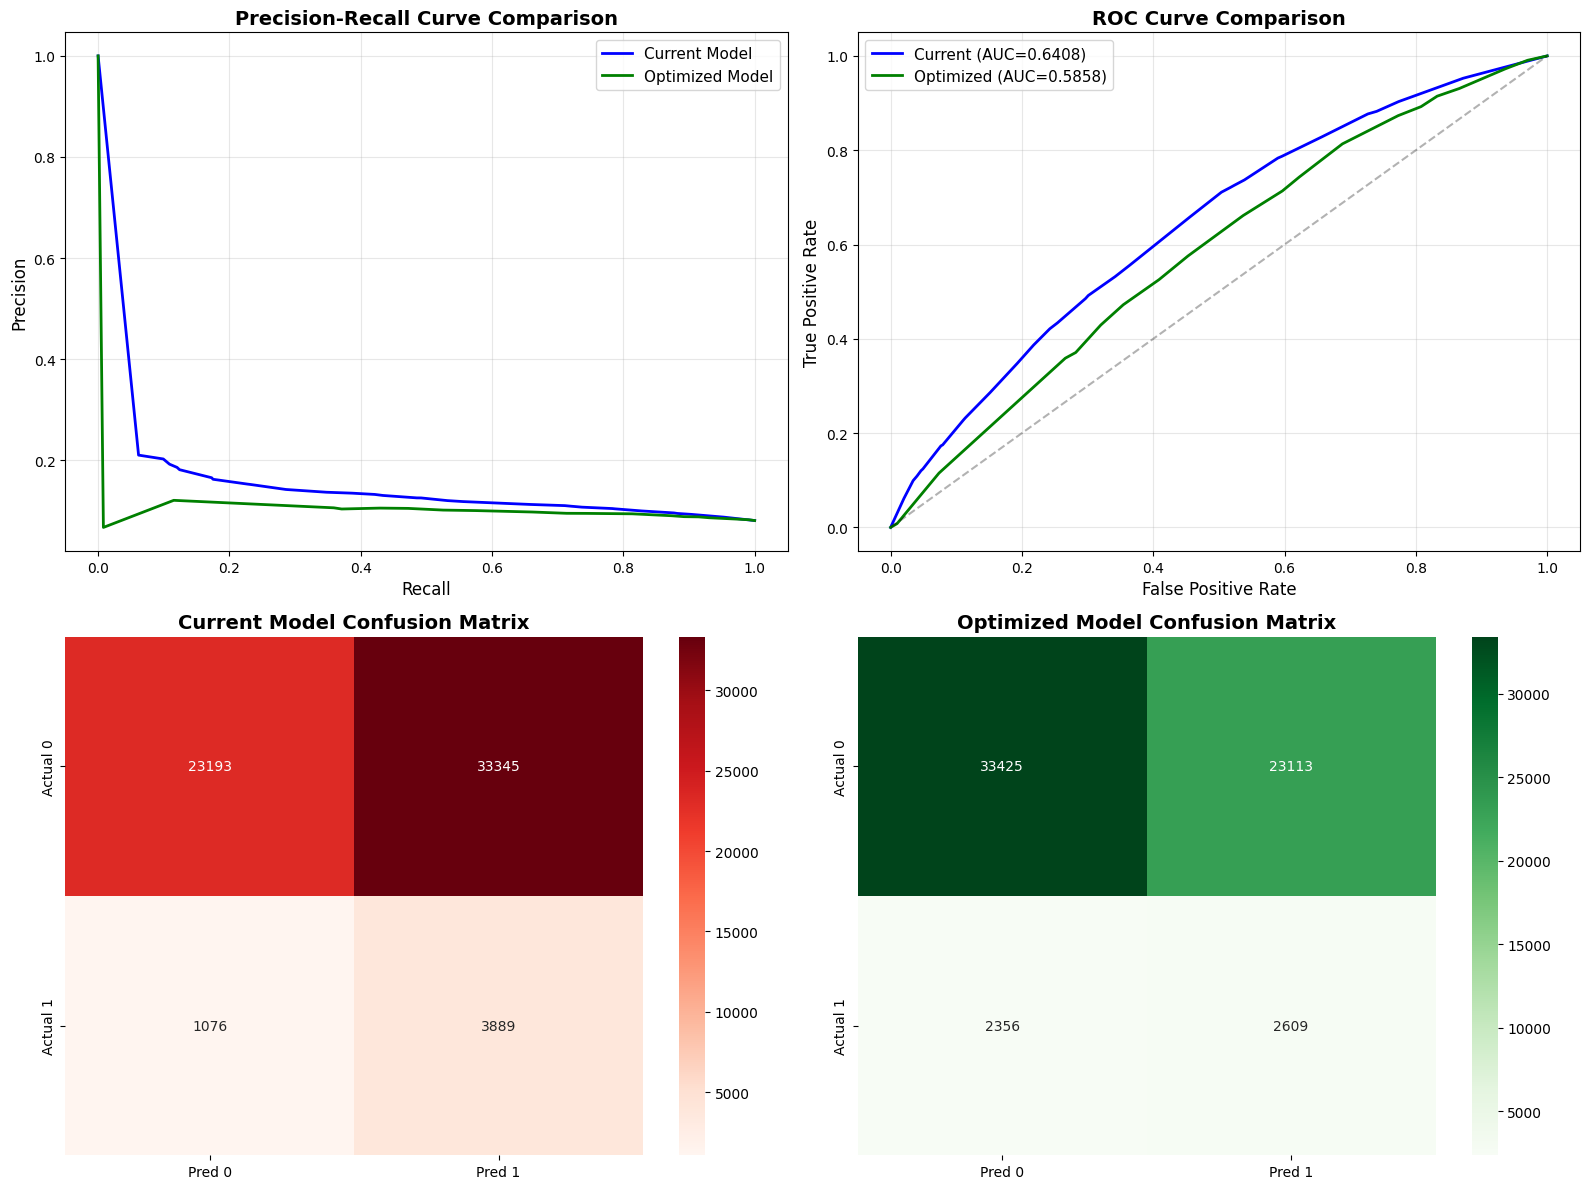

In [18]:
# Visualize Improvements
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Precision-Recall Comparison
from sklearn.metrics import precision_recall_curve

precision_old, recall_old, _ = precision_recall_curve(y_test, y_prob)
precision_new, recall_new, _ = precision_recall_curve(y_test, y_prob_optimized)

axes[0, 0].plot(recall_old, precision_old, 'b-', linewidth=2, label='Current Model')
axes[0, 0].plot(recall_new, precision_new, 'g-', linewidth=2, label='Optimized Model')
axes[0, 0].set_xlabel('Recall', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: ROC Curve Comparison
from sklearn.metrics import roc_curve

fpr_old, tpr_old, _ = roc_curve(y_test, y_prob)
fpr_new, tpr_new, _ = roc_curve(y_test, y_prob_optimized)

axes[0, 1].plot(fpr_old, tpr_old, 'b-', linewidth=2, label=f'Current (AUC={roc_auc:.4f})')
axes[0, 1].plot(fpr_new, tpr_new, 'g-', linewidth=2, label=f'Optimized (AUC={roc_auc_opt:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix - Current
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Reds', ax=axes[1, 0],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 0].set_title('Current Model Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 4: Confusion Matrix - Optimized
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 1].set_title('Optimized Model Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [19]:
# Save Optimized Model
joblib.dump(lgb_optimized, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_best_model.pkl")
joblib.dump(best_threshold_opt, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_threshold.pkl")

# Enhanced metadata
best_model_metadata = {
    'model_type': 'LightGBM Optimized',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'resampling_method': f'SMOTE (sampling_strategy={desired_ratio_v2})',
    'scale_pos_weight': scale_pos_weight_v2,
    'best_threshold': best_threshold_opt,
    'threshold_optimization': 'F1-score maximization',
    'roc_auc': roc_auc_opt,
    'f1_score_class1': f1_score(y_test, y_pred_final, pos_label=1),
    'recall_class1': recall_score(y_test, y_pred_final, pos_label=1),
    'precision_class1': precision_score(y_test, y_pred_final, pos_label=1),
    'business_cost': int(business_cost_final),
    'hyperparameters': lgb_optimized.get_params(),
    'feature_importance': dict(zip(lgb_optimized.feature_name_, lgb_optimized.feature_importances_.tolist()))
}

joblib.dump(best_model_metadata, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_model_metadata.pkl")

print("="*80)
print("✅ OPTIMIZED MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Model: lightgbm_best_model.pkl")
print(f"📁 Threshold: best_threshold.pkl")
print(f"📁 Metadata: best_model_metadata.pkl")
print(f"\n🎯 Final Performance:")
print(f"  Precision: {precision_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  ROC-AUC: {roc_auc_opt:.4f}")
print(f"\n💰 Business Cost: ${business_cost_final:,}")
print(f"\n🚀 Model ready for production!")

✅ OPTIMIZED MODEL SAVED SUCCESSFULLY
📁 Model: lightgbm_best_model.pkl
📁 Threshold: best_threshold.pkl
📁 Metadata: best_model_metadata.pkl

🎯 Final Performance:
  Precision: 0.1014
  Recall: 0.5255
  F1-Score: 0.1700
  ROC-AUC: 0.5858

💰 Business Cost: $3,511,650

🚀 Model ready for production!
